In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mytorch.nn.activation import ReLU, Sigmoid, Tanh, LinearActivation
from mytorch.nn.initialization import Xavier, He
from mytorch.nn.linear import Linear
from mytorch.nn.loss import CrossEntropyLoss, L2Loss
from mytorch.optim.optimizer import SGD, Adam
from models.mlp import MLP
import numpyNN

In [2]:
# based on dataset.py from IML HW 6 
def one_hot_encoding(y, num_classes=2):
    one_hot = np.eye(num_classes)[y.astype(int).flatten()]
    return one_hot

In [3]:
def train_mlp(mlp, x_train, y_train, opt_loss, opt_optim, num_epoch=20):
    assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have the same length"

    # Initialize tracking variables
    best_loss = float('inf')
    best_params = None
    train_loss = []  # List to store mean loss for each epoch
    train_accuracy = []  # List to store accuracy for each epoch

    y_train_encoded = one_hot_encoding(y_train)  # Assuming one_hot_encoding function is defined elsewhere

    index = np.arange(x_train.shape[0])

    for epoch in range(num_epoch):
        np.random.shuffle(index)
        train_data = x_train[index]
        train_labels = y_train_encoded[index]

        y_pred = mlp.forward(train_data)
        loss = opt_loss.forward(y_pred, train_labels)
        mean_loss = np.mean(loss)
        train_loss.append(mean_loss)

        # Check for best model
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_params = mlp.get_parameters()  # Assuming get_parameters returns a deep copy

        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(train_labels, axis=1)

        accuracy = np.sum(predicted_labels == true_labels) / len(train_data)
        train_accuracy.append(accuracy)

        dLdZ = opt_loss.backward(y_pred, train_labels)
        mlp.backward(dLdZ)
        opt_optim.step(mlp.get_parameters())
        opt_optim.zero_grad(mlp.get_parameters())

        print(f"Epoch: {epoch}, Loss: {mean_loss}, Accuracy: {accuracy}")

    # After training, set the model to the best parameters found
    if best_params is not None:
        mlp.set_parameters(best_params)

    train_logs = {"train_loss": train_loss, "train_accuracy": train_accuracy}
    return train_logs


In [4]:
def test_mlp(mlp, x_test, y_test, opt_loss, num_epoch = 20):
    """
    Parameters
    ----------
    Returns
    -------
        [0] Mean test loss.
        [1] Test accuracy.
    """
    assert(x_test.shape[0] == y_test.shape[0]) # "x_test and y_test must have same length"
    
    test_loss = []
    test_accuracy = [ ]
    y_test = one_hot_encoding(y_test)

    for epoch in range(num_epoch):
        y_pred = mlp.forward(x_test)
        loss = opt_loss.forward(y_pred, y_test) 
        loss = np.mean(loss)
        test_loss.append(loss)
        
        predicted_labels = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_test, axis=1) 
        
        accuracy = np.sum(predicted_labels == true_labels) / len(x_test)
        test_accuracy.append(accuracy)  
        print(f"Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    
    test_logs = {"test_loss": test_loss, "test_accuracy": test_accuracy }
    return test_logs

In [5]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'linear-separable',nTrain=200, nTest=100)

In [8]:
dim_in, dim_out = x_train.shape[1], 2
hidden_neuron_list = [2,4]
activation_list = ['ReLU', 'ReLU', 'Sigmoid']
opt_init = None
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = SGD(lr_decay=1, decay_iter=30)

In [9]:
train_logs = train_mlp(mlp, x_train, y_train, opt_loss, opt_optim, num_epoch = 20)

0 Initialized v
1 v
1 v
1 v
1 v
1 v
1 v
Epoch: 0, Loss: 0.002616091117233813, Accuracy: 0.155
2 v
2 v
2 v
2 v
2 v
2 v
Epoch: 1, Loss: 0.002499955524826122, Accuracy: 0.545
3 v
3 v
3 v
3 v
3 v
3 v
Epoch: 2, Loss: 0.002499865111194739, Accuracy: 0.545
4 v
4 v
4 v
4 v
4 v
4 v
Epoch: 3, Loss: 0.002499733761168719, Accuracy: 0.545
5 v
5 v
5 v
5 v
5 v
5 v
Epoch: 4, Loss: 0.002499566136409675, Accuracy: 0.545
6 v
6 v
6 v
6 v
6 v
6 v
Epoch: 5, Loss: 0.0024993665591945026, Accuracy: 0.545
7 v
7 v
7 v
7 v
7 v
7 v
Epoch: 6, Loss: 0.0024991390190061418, Accuracy: 0.545
8 v
8 v
8 v
8 v
8 v
8 v
Epoch: 7, Loss: 0.0024988871831895703, Accuracy: 0.545
9 v
9 v
9 v
9 v
9 v
9 v
Epoch: 8, Loss: 0.0024986144104741947, Accuracy: 0.545
10 v
10 v
10 v
10 v
10 v
10 v
Epoch: 9, Loss: 0.0024983237664162944, Accuracy: 0.545
11 v
11 v
11 v
11 v
11 v
11 v
Epoch: 10, Loss: 0.0024980180400201446, Accuracy: 0.545
12 v
12 v
12 v
12 v
12 v
12 v
Epoch: 11, Loss: 0.0024976997609624553, Accuracy: 0.545
13 v
13 v
13 v
13 v
1

In [10]:
train_logs

{'train_loss': [0.002616091117233813,
  0.002499955524826122,
  0.002499865111194739,
  0.002499733761168719,
  0.002499566136409675,
  0.0024993665591945026,
  0.0024991390190061418,
  0.0024988871831895703,
  0.0024986144104741947,
  0.0024983237664162944,
  0.0024980180400201446,
  0.0024976997609624553,
  0.0024973712169787284,
  0.002497034471077971,
  0.0024966913783385208,
  0.002496343602106628,
  0.002495992629474017,
  0.0024956397859536524,
  0.0024952862493065205,
  0.00249493306249821],
 'train_accuracy': [0.155,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545]}

In [11]:
mlp_test = mlp
test_logs = test_mlp(mlp_test, x_test, y_test, opt_loss, num_epoch = 20)

Epoch: 0, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 1, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 2, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 3, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 4, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 5, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 6, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 7, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 8, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 9, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 10, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 11, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 12, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 13, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 14, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 15, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 16, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 17, Loss: 0.005013820468604217, Accuracy: 0.45
Epoch: 18, Loss: 0.005013820468604217,

In [12]:
logs = {**train_logs, **test_logs}
logs

{'train_loss': [0.002616091117233813,
  0.002499955524826122,
  0.002499865111194739,
  0.002499733761168719,
  0.002499566136409675,
  0.0024993665591945026,
  0.0024991390190061418,
  0.0024988871831895703,
  0.0024986144104741947,
  0.0024983237664162944,
  0.0024980180400201446,
  0.0024976997609624553,
  0.0024973712169787284,
  0.002497034471077971,
  0.0024966913783385208,
  0.002496343602106628,
  0.002495992629474017,
  0.0024956397859536524,
  0.0024952862493065205,
  0.00249493306249821],
 'train_accuracy': [0.155,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545,
  0.545],
 'test_loss': [0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604217,
  0.005013820468604

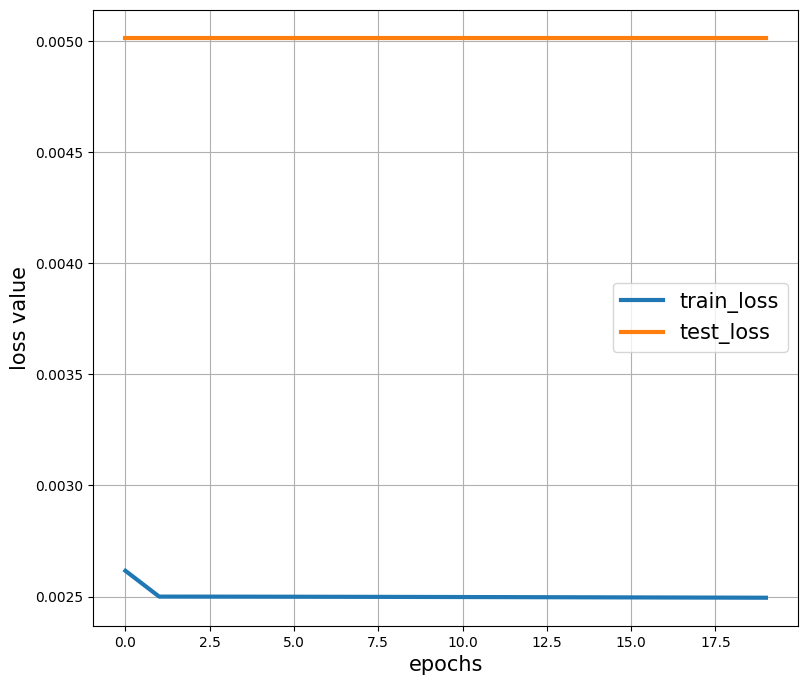

In [13]:
numpyNN.plot_loss(logs)

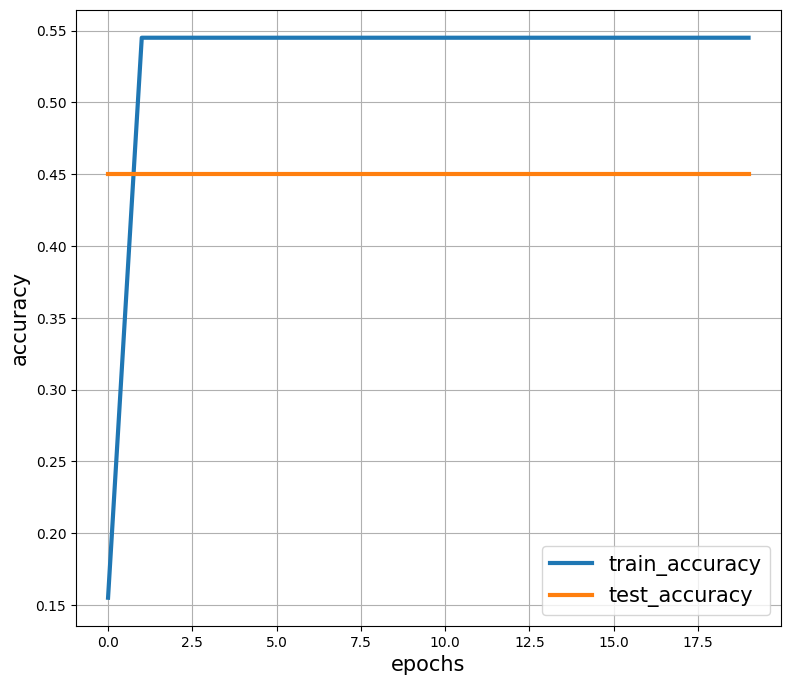

In [14]:
numpyNN.plot_accuracy(logs)

In [15]:

def plot_decision_boundary(X, y, model, boundry_level=None):
    """
    Plots the decision boundary for the model prediction
    :param X: input data
    :param y: true labels
    :param model: your MLP model
    :boundry_level: Determines the number and positions of the contour lines / regions.
    :return:
    """
    print(X.shape)
    print(y.shape)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    def predict(X):
        # Assuming your model's forward method returns the class probabilities
        # and you're interested in the class with the highest probability
        y_pred = model.forward(X)
        # Convert probabilities to class labels (assuming binary classification)
        return np.argmax(y_pred, axis=1)


    # Use the predict function as pred_fn
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.7, levels=boundry_level, cmap='viridis_r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), alpha=0.7,s=50, cmap='viridis_r', edgecolor='k')

(200, 2)
(200, 1)


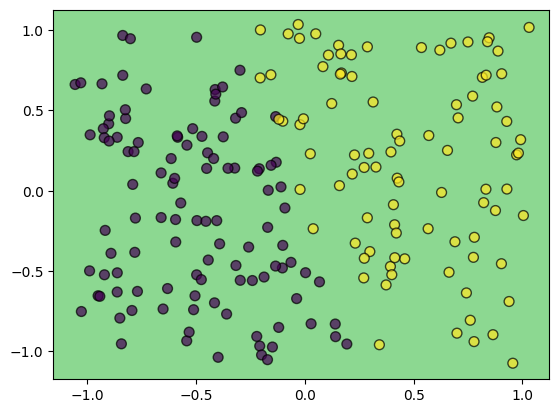

In [16]:
# predicted_labels = np.argmax(y_pred, axis=1)
plot_decision_boundary(x_train, y_train, mlp_test , boundry_level=None)

---

In [17]:

x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'linear-separable',nTrain=2, nTest=2)

In [22]:
dim_in, dim_out = x_train.shape[1], 2
hidden_neuron_list = [2,4]
activation_list = ['ReLU', 'ReLU', 'Sigmoid']
opt_init = None
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = SGD(lr_decay=1, decay_iter=30)

print(mlp.summary())

Model Summary
-------------
Layer 1: Linear - Input Dim: 2, Output Dim: 2, Parameters: 6
Layer 2: ReLU
Layer 3: Linear - Input Dim: 2, Output Dim: 4, Parameters: 12
Layer 4: ReLU
Layer 5: Linear - Input Dim: 4, Output Dim: 2, Parameters: 10
Layer 6: Sigmoid
Total Parameters: 28
None


In [23]:
print(mlp.get_parameters())

[{'params': array([[ 0.81526991,  0.22909795],
       [-1.02617878,  0.47752547]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[ 1.29269823, -0.73145824, -1.60540226,  0.98947618],
       [ 0.11081461, -0.38093141,  0.11495917,  0.34531264]]), 'grad': 0.0}, {'params': array([[0., 0., 0., 0.]]), 'grad': 0.0}, {'params': array([[-1.73495876,  1.65835111],
       [ 2.29977152, -0.47113526],
       [ 1.26271548, -1.17051545],
       [ 1.0657892 , -0.69993739]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}]


In [24]:
y_pred = mlp.forward(x_train)
y_train = one_hot_encoding(y_train)
loss = opt_loss.forward(y_pred, y_train)

In [25]:
y_pred[1:4], y_train[1:4], loss[1:4]

(array([[0.49148908, 0.51897857]]), array([[1., 0.]]), array([0.26396106]))

In [26]:
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_train, axis=1)  # Adjust this line if train_y is not one-hot encoded
accuracy = np.sum(predicted_labels == true_labels) / len(x_train)
print(accuracy)

0.0


In [27]:
print("Before backward:", mlp.layers[0].parameters[0]['params'].mean())

Before backward: 0.12392863696006


In [28]:
dLdZ = opt_loss.backward(y_pred, y_train)
dLdZ[1:10]

array([[-0.50851092,  0.51897857]])

In [29]:
dLdZ.shape

(2, 2)

In [30]:
mlp.get_parameters()

[{'params': array([[ 0.81526991,  0.22909795],
         [-1.02617878,  0.47752547]]),
  'grad': 0.0},
 {'params': array([[0., 0.]]), 'grad': 0.0},
 {'params': array([[ 1.29269823, -0.73145824, -1.60540226,  0.98947618],
         [ 0.11081461, -0.38093141,  0.11495917,  0.34531264]]),
  'grad': 0.0},
 {'params': array([[0., 0., 0., 0.]]), 'grad': 0.0},
 {'params': array([[-1.73495876,  1.65835111],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.0657892 , -0.69993739]]),
  'grad': 0.0},
 {'params': array([[0., 0.]]), 'grad': 0.0}]

In [31]:
mlp.backward(dLdZ)

array([[ 0.81526991, -1.02617878],
       [ 1.04436786, -0.54865331]])

In [32]:
mlp.get_parameters()

[{'params': array([[ 0.81526991,  0.22909795],
         [-1.02617878,  0.47752547]]),
  'grad': array([[0.78397459, 0.40706704],
         [0.05325339, 0.26387176]])},
 {'params': array([[0., 0.]]), 'grad': array([[2, 1]])},
 {'params': array([[ 1.29269823, -0.73145824, -1.60540226,  0.98947618],
         [ 0.11081461, -0.38093141,  0.11495917,  0.34531264]]),
  'grad': array([[0.58450339, 0.        , 0.        , 0.58450339],
         [0.21926371, 0.        , 0.        , 0.21926371]])},
 {'params': array([[0., 0., 0., 0.]]), 'grad': array([[2, 0, 0, 2]])},
 {'params': array([[-1.73495876,  1.65835111],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.0657892 , -0.69993739]]),
  'grad': array([[-0.11319316,  0.1134724 ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [-0.09390094,  0.09425557]])},
 {'params': array([[0., 0.]]), 'grad': array([[-0.2749868 ,  0.27748981]])}]

In [33]:
print("Before optimization:", mlp.layers[0].parameters[0]['params'].mean())

Before optimization: 0.12392863696006


In [34]:
opt_optim.step(mlp.get_parameters())

0 Initialized v
1 v
1 v
1 v
1 v
1 v
1 v


In [35]:
mlp.get_parameters()

[{'params': array([[ 0.80743016,  0.22502728],
         [-1.02671131,  0.47488675]]),
  'grad': array([[0.78397459, 0.40706704],
         [0.05325339, 0.26387176]])},
 {'params': array([[-0.02, -0.01]]), 'grad': array([[2, 1]])},
 {'params': array([[ 1.2868532 , -0.73145824, -1.60540226,  0.98363114],
         [ 0.10862197, -0.38093141,  0.11495917,  0.34312001]]),
  'grad': array([[0.58450339, 0.        , 0.        , 0.58450339],
         [0.21926371, 0.        , 0.        , 0.21926371]])},
 {'params': array([[-0.02,  0.  ,  0.  , -0.02]]),
  'grad': array([[2, 0, 0, 2]])},
 {'params': array([[-1.73382683,  1.65721638],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.06672821, -0.70087994]]),
  'grad': array([[-0.11319316,  0.1134724 ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [-0.09390094,  0.09425557]])},
 {'params': array([[ 0.00274987, -0.0027749 ]]),
  'grad': array([[-0.2749868 ,  0.27748981]])}]

In [36]:
print("After optimization:", mlp.layers[0].parameters[0]['params'].mean())

After optimization: 0.1201582200088189


In [37]:
opt_optim.zero_grad(mlp.get_parameters())

In [38]:
mlp.get_parameters()

[{'params': array([[ 0.80743016,  0.22502728],
         [-1.02671131,  0.47488675]]),
  'grad': array([[0., 0.],
         [0., 0.]])},
 {'params': array([[-0.02, -0.01]]), 'grad': array([[0, 0]])},
 {'params': array([[ 1.2868532 , -0.73145824, -1.60540226,  0.98363114],
         [ 0.10862197, -0.38093141,  0.11495917,  0.34312001]]),
  'grad': array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]])},
 {'params': array([[-0.02,  0.  ,  0.  , -0.02]]),
  'grad': array([[0, 0, 0, 0]])},
 {'params': array([[-1.73382683,  1.65721638],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.06672821, -0.70087994]]),
  'grad': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]])},
 {'params': array([[ 0.00274987, -0.0027749 ]]), 'grad': array([[0., 0.]])}]

In [39]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TorchMLP(nn.Module):
#     def __init__(self, input_dim, hidden_dims, output_dim):
#         super(TorchMLP, self).__init__()
#         # Define the first hidden layer
#         self.hidden1 = nn.Linear(input_dim, hidden_dims[0])
#         # Define the second hidden layer
#         self.hidden2 = nn.Linear(hidden_dims[0], hidden_dims[1])
#         # Define the output layer
#         self.output = nn.Linear(hidden_dims[1], output_dim)
    
#     def forward(self, x):
#         # Pass the input through the first hidden layer and apply ReLU
#         x = F.relu(self.hidden1(x))
#         # Pass the result through the second hidden layer and apply ReLU
#         x = F.relu(self.hidden2(x))
#         # Pass the result through the output layer and apply Softmax
#         # Note: Softmax is typically applied outside the model for numerical stability
#         x = self.output(x)
#         return x

# # Initialize the model
# input_dim = 2  # Assuming 2 features in the input data
# hidden_neuron_list = [2,3]
# output_dim = 2  # Output dimension for binary classification (use with softmax)
# model = TorchMLP(input_dim, hidden_neuron_list, output_dim)

# # Print the model summary
# print(model)

# # Calculate the number of parameters
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total number of parameters: {total_params}")


In [44]:
# y_train = one_hot_encoding(y_train)
dim_in, dim_out = x_train.shape[1], 2
hidden_neuron_list = [2,2]
activation_list = ['Tanh', 'ReLU', 'Sigmoid']
opt_init = None
opt_loss = CrossEntropyLoss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(lr_decay=1, decay_iter=30)

In [45]:
for i in range(3):
    print('Epoch', i)
    print(mlp.get_parameters())
    y_pred = mlp.forward(x_train)
    loss = opt_loss.forward(y_pred, y_train)
    # y_pred[1:4], y_train[1:4], loss[1:4]
    predicted_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_train, axis=1)  # Adjust this line if train_y is not one-hot encoded
    accuracy = np.sum(predicted_labels == true_labels) / len(x_train)
    print(accuracy)
    print("Before backward:", mlp.layers[0].parameters[0]['params'].mean())
    print(mlp.get_parameters())

    dLdZ = opt_loss.backward(y_pred, y_train)
    dLdZ[1:10]
    dLdZ.shape
    print("After backward:", mlp.layers[0].parameters[0]['params'].mean())
    print(mlp.get_parameters())
    mlp.backward(dLdZ)
    print("Before optimization:", mlp.layers[0].parameters[0]['params'].mean())
    opt_optim.step(mlp.get_parameters())
    print("After optimization:", mlp.layers[0].parameters[0]['params'].mean())
    opt_optim.zero_grad(mlp.get_parameters())
    print("After 0:", mlp.layers[0].parameters[0]['params'].mean())
    print(mlp.get_parameters())

Epoch 0
[{'params': array([[-0.99838235, -0.3676376 ],
       [ 1.73719932,  0.59361275]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[-0.54236358, -1.71967238],
       [-0.57890879,  1.42694855]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[0.27699691, 0.78966713],
       [0.32207411, 0.70039238]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}]
0.5
Before backward: 0.24119802808082583
[{'params': array([[-0.99838235, -0.3676376 ],
       [ 1.73719932,  0.59361275]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[-0.54236358, -1.71967238],
       [-0.57890879,  1.42694855]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[0.27699691, 0.78966713],
       [0.32207411, 0.70039238]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}]
After backward: 0.24119802808082583
[{'params': array([[-0.99838235, -0.3676376 ],
       [ 1.73719932,  0.5936